In [40]:
#We import our packages
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the first dataset: Life expectancy at birth
We use the first csv dataset to calculate the **life expectancy** in each state of USA.
We will need to clean our dataset in order to extract, from data related to the different counties, the *average life expectancy* in each state of US.

In [58]:
#We load our dataset
life_expectancy_original=pd.read_csv("Data/U.S._Life_Expectancy_at_Birth_by_State_and_Census_Tract_-_2010-2015.csv")
life_expectancy_original

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error
0,Alabama,Autauga County,201.0,73.1,56.3 - 75.0,2.2348
1,Alabama,Autauga County,202.0,76.9,75.1 - 77.4,3.3453
2,Alabama,Autauga County,204.0,75.4,75.1 - 77.4,1.0216
3,Alabama,Autauga County,205.0,79.4,77.5 - 79.4,1.1768
4,Alabama,Autauga County,206.0,73.1,56.3 - 75.0,1.5519
...,...,...,...,...,...,...
73104,Virginia,NaN,NaN,79.4,77.5 - 79.4,0.0250
73105,Washington,NaN,NaN,80.3,79.5 - 81.5,0.0270
73106,West Virginia,NaN,NaN,75.3,75.1 - 77.4,0.0520
73107,Wisconsin,NaN,NaN,79.6,79.5 - 81.5,0.0290


We can notice how some values are missing. In some cases we miss the reference about the Census Tract, in other we have it, but the life expectancy is not declared, in other cases again even the County is missing.
We decide to drop all the missing values, so that they would not affect our analysis.

In [59]:
life_expectancy_original=life_expectancy_original.dropna()
life_expectancy_original

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error
0,Alabama,Autauga County,201.00,73.1,56.3 - 75.0,2.2348
1,Alabama,Autauga County,202.00,76.9,75.1 - 77.4,3.3453
2,Alabama,Autauga County,204.00,75.4,75.1 - 77.4,1.0216
3,Alabama,Autauga County,205.00,79.4,77.5 - 79.4,1.1768
4,Alabama,Autauga County,206.00,73.1,56.3 - 75.0,1.5519
...,...,...,...,...,...,...
67462,Wyoming,Washakie County,2.00,80.1,79.5 - 81.5,2.6916
67463,Wyoming,Washakie County,3.01,79.9,79.5 - 81.5,2.8024
67464,Wyoming,Washakie County,3.02,81.8,81.6 - 97.5,2.0776
67465,Wyoming,Weston County,9511.00,79.0,77.5 - 79.4,1.0697


In [60]:
life_expectancy_columns=life_expectancy_original[['State','County','Census Tract Number','Life Expectancy']]
life_expectancy_columns
#We drop the column about the Life Expectancy Range, as we need a precise calculation of our value 
#and not a range, while we effectuate our analysis about the average life expectancy, and do not care
#about the standard error for each Census Tract

,State,County,Census Tract Number,Life Expectancy
0,Alabama,Autauga County,201.00,73.1
1,Alabama,Autauga County,202.00,76.9
2,Alabama,Autauga County,204.00,75.4
3,Alabama,Autauga County,205.00,79.4
4,Alabama,Autauga County,206.00,73.1
...,...,...,...,...
67462,Wyoming,Washakie County,2.00,80.1
67463,Wyoming,Washakie County,3.01,79.9
67464,Wyoming,Washakie County,3.02,81.8
67465,Wyoming,Weston County,9511.00,79.0


## What is a census tract? (From https://en.wikipedia.org/wiki/Census_tract)
A *census tract*, census area, census district or meshblock is a geographic region defined for the purpose of taking a census. Sometimes these coincide with the limits of cities, towns or other administrative areas and several tracts commonly exist within a county. In unincorporated areas of the United States these are often arbitrary, except for coinciding with political lines.
Census tracts represent the **smallest territorial entity for which population data are available in many countries**. In the United States, census tracts are subdivided into block groups and census blocks. In Canada they are divided into dissemination areas. In the U.S., census tracts are "designed to be relatively homogeneous units with respect to population characteristics, economic status, and living conditions" and "average about 4,000 inhabitants".

## How will it be useful for our calculations?
From our dataset, we can see how different counties have different numbers of census tracts.
To calculate our value of life expectancy for each state, we should know how many people are in each census tract, and calculate the weighted average.
But we do not have this information!

*Census tracts generally contain between 1,000 and 8,000 people with an optimum size of 4,000 people. Census tract boundaries are delineated with the intention of being stable over many decades, so they generally follow relatively permanent visible features.* (From https://pitt.libguides.com/uscensus/understandinggeography)
They are made in order to be **more or less all of the same dimension!**
Calculating the average of all the census tract values should not affect that much our analysis!

In [61]:
#We group our data per state
life_expectancy_grouped=life_expectancy_columns.groupby(life_expectancy_columns.State)
life_expectancy_grouped.head()

,State,County,Census Tract Number,Life Expectancy
0,Alabama,Autauga County,201.0,73.1
1,Alabama,Autauga County,202.0,76.9
2,Alabama,Autauga County,204.0,75.4
3,Alabama,Autauga County,205.0,79.4
4,Alabama,Autauga County,206.0,73.1
...,...,...,...,...
67349,Wyoming,Albany County,9627.0,80.4
67350,Wyoming,Albany County,9628.0,82.0
67351,Wyoming,Albany County,9629.0,81.1
67352,Wyoming,Albany County,9630.0,76.8


In [62]:
#We calculate the mean 
life_expectancy=life_expectancy_grouped.mean()[['Life Expectancy']]
life_expectancy.columns=['Life_Expectancy']
life_expectancy

,Life_Expectancy
State,
Alabama,74.813987
Alaska,78.915541
Arizona,78.364742
Arkansas,75.626900
California,80.231014
Colorado,79.465953
Connecticut,80.101405
Delaware,77.793939
District of Columbia,76.407879


We finally have the first information we need: the **life expectancy in every state of USA.**
We plot our obtained data in order to identify outliers and evaluate wheter we need to do something else.

(array([2., 4., 2., 1., 5., 2., 2., 4., 5., 7., 3., 4., 5., 1., 2.]),
 array([74.81398728, 75.24738104, 75.6807748 , 76.11416855, 76.54756231,
        76.98095606, 77.41434982, 77.84774357, 78.28113733, 78.71453108,
        79.14792484, 79.58131859, 80.01471235, 80.44810611, 80.88149986,
        81.31489362]),
 <a list of 15 Patch objects>)

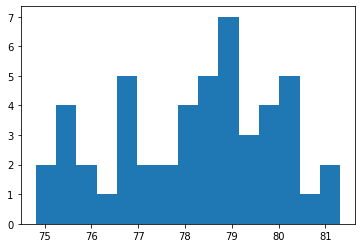

In [63]:
plt.hist(life_expectancy.Life_Expectancy, bins=15)

We can see how data seem to be quite homogeneous! Our work seems to be fine!

In [70]:
#We sort our data to see which state is the "Life Expectancy Champion!"
life_expectancy_sorted=life_expectancy.sort_values('Life_Expectancy', ascending=False)
life_expectancy_sorted

,Life_Expectancy
State,
Hawaii,81.314894
Vermont,81.022286
Minnesota,80.468912
Massachusetts,80.340246
New York,80.326875
California,80.231014
Wyoming,80.161017
Connecticut,80.101405
New Hampshire,79.956028


**Hawaii  is the life expectancy champion!** We will expect in our final analysis that this state (with other like Vermont or Minnesota) will have high rates when giving importance to the quality of life, while states like Louisiana, Minnesota or Alabama will be less rated.

## Loading the second dataset: Disposable personal income